In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy import linalg
EPSILON = 1.1920929e-07
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import scanpy as sc
import pandas as pd
import spatialdm as sdm
import squidpy as sq
import tqdm
import adjustText
from scipy.optimize import minimize, minimize_scalar
from sklearn.neighbors import NearestNeighbors
import importlib

In [2]:
import warnings
import networkx as nx

# Silencing FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
def plot_raw_lr_boundary_expression(
    lig_rec_idx,
    int_type,
    loc_df,
    int_edges_new
):
    lr_pairs_ct = int_edges_new.loc[
        int_edges_new.interaction == int_type,
        :
    ].copy()
    genes_to_show = lig_rec_idx.split("_")
    genes_to_show = [gene for gene in genes_to_show if gene in count_df.columns]
    
    #sns.scatterplot(data = int_loc_df, x = "x", y = "y", s = 8, hue='dist_from_z', ax=ax, alpha=0.8,label='start')
    selected_cells = list(
        set(lr_pairs_ct.cell1.unique()).union(
            lr_pairs_ct.cell2.unique()   
        )
    )
    
    fig, ax = plt.subplots(1,len(genes_to_show),
                           figsize=(5*len(genes_to_show),5))
    for i,gene in enumerate(genes_to_show):
        ax[i].scatter(loc_df['x'], loc_df['y'], c= "grey", s=0.4,alpha = 0.4)
        colors = np.array(count_df.loc[selected_cells, gene].values)
        tmp = loc_df.loc[selected_cells,:].copy()
        tmp.loc[:, 'gene'] = colors
        sns.scatterplot(x='x', y='y', hue='gene',
                             palette='Reds',s=20, data=tmp,alpha=0.7,ax= ax[i])

        norm = Normalize(tmp['gene'].min(), tmp['gene'].max())
        sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
        sm.set_array([])
        
        # Remove the legend and add a colorbar
        ax[i].get_legend().remove()
        
    
        ax[i].set_title(gene + "\n" + int_type.replace('=',' → '))
        ax[i].figure.colorbar(sm,ax=ax[i])
        ax[i].invert_yaxis()
        ax[i].set_xticks([])
        ax[i].set_yticks([]);
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['bottom'].set_visible(False)
        ax[i].spines['left'].set_visible(False)
    
        ax[i].set_xlabel("spatial1")
        ax[i].set_ylabel("spatial2")
    plt.tight_layout()
    plt.show()


from matplotlib.colors import Normalize

def plot_lr_interaction_boundary_activity_color(
    df_lig_rec,
    lig_rec_idx,
    int_type,
    cop_df_dict,
    loc_df,
    int_edges_new,
    umi_sums,
    data_list_dict,
    dist_list_dict = None
):
    
    idx = df_lig_rec.index.get_loc(lig_rec_idx)
    g11, g12 = int_type.split('=')
    if dist_list_dict is None:
        
        row = cop_df_dict[int_type].loc[lig_rec_idx,:]
        coeff = row.copula_coeff
        mu_x = row.mu_x
        mu_y = row.mu_y
        loglikvec =  model.log_joint_lik_perm(
            [coeff,mu_x,mu_y],
            umi_sums[int_type][g11],
            umi_sums[int_type][g12],
            data_list_dict[int_type][idx][0],
            data_list_dict[int_type][idx][1],
            perm=20,
            DT=False,
            model='copula',
            return_sum=False
        )
        loglikvec = -loglikvec
    else:
        g11, g12 = int_name.split('=')
        row = cop_df_dict[int_type].loc[lig_rec_idx,:]
        rho_zero = row.rho_zero
        rho_one = row.rho_one
        mu_x = row.mu_x
        mu_y = row.mu_y
        loglikvec =  model.log_joint_lik_perm_dist(
            [rho_zero,rho_one,mu_x,mu_y],
            umi_sums[int_type][g11],
            umi_sums[int_type][g12],
            data_list_dict[int_type][idx][0],
            data_list_dict[int_type][idx][1],
            dist_list_dict[int_name],
            perm=20,
            DT=False,
            model='copula',
            return_sum=False
        )
        loglikvec = -loglikvec
        
    lr_pairs_ct = int_edges_new.loc[
        int_edges_new.interaction == int_type,
        :
    ].copy()
    fig, ax = plt.subplots(figsize=(6,6))
    cmap = plt.get_cmap('Reds')
    norm = Normalize(vmin=min(loglikvec), vmax=max(loglikvec))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([]) 
    # Remove the legend and add a colorbar
    ax.scatter(loc_df['x'], loc_df['y'], c= "grey", s=0.4,alpha = 0.4)
    #sns.scatterplot(data = int_loc_df, x = "x", y = "y", s = 8, hue='dist_from_z', ax=ax, alpha=0.8,label='start')
    
    for i,edge in enumerate(lr_pairs_ct[['cell1', 'cell2']].values):
        color = cmap(norm(loglikvec[i]))
        x1, y1 = loc_df.loc[  edge[0], 'x' ], loc_df.loc[  edge[0], 'y' ]
        x2, y2 = loc_df.loc[  edge[1], 'x' ], loc_df.loc[  edge[1], 'y' ]
        ax.plot([x1, x2], [y1, y2], color=color, marker='o', 
                linestyle='-', markersize=0.5,linewidth=1)
    cbar = plt.colorbar(sm, ax=ax, label='Loglikelihood')
    #ax.get_legend().remove()
    ax.set_title(lig_rec_idx + "\n" + int_type.replace('=',' → '))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.gca().invert_yaxis()
    plt.gca().set_xticks([])
    plt.gca().set_yticks([]);
    plt.xlabel("spatial1")
    plt.ylabel("spatial2")

In [4]:
adata = sc.read_h5ad(
    'data/mosta_mouse_embryo/E9.5_E1S1.MOSTA.h5ad')

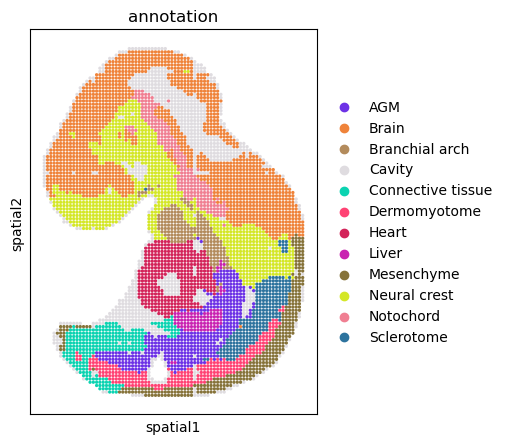

In [5]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
sc.pl.spatial(adata, color = ['annotation'], spot_size=1, ax =ax)

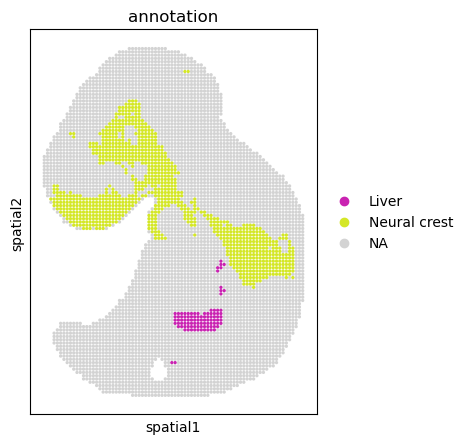

In [6]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
sc.pl.spatial(adata, color = ['annotation'], groups = ['Liver', 'Neural crest'],
              spot_size=1, ax =ax)

In [55]:
adata.shape

(5913, 25568)

In [8]:
import sys
sys.path.append("/Users/hs0424/Workspace/copulacci/src/copulacci/")
import cci
import spatial
import model
import simulation

/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
sdm.extract_lr(adata, 'mouse', min_cell=20)

In [10]:
adata.obs['celltype'] = adata.obs.annotation

In [11]:
adata_sdm = adata.copy()

In [12]:
adata.uns.keys()

dict_keys(['annotation_colors', 'mean', 'ligand', 'receptor', 'num_pairs', 'geneInter'])

In [13]:
importlib.reload(spatial)

<module 'spatial' from '/Users/hs0424/Workspace/copulacci/src/copulacci/spatial.py'>

In [14]:
adata.obs = adata.obs[['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'annotation', 'celltype']]

In [15]:
adata.var = adata.var[['n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts',
       'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts']]

In [18]:
spatial.construct_spatial_network(adata, n_rings=2, 
                                  data_type='visium')

Constructing spatial network with visium


In [19]:
print(adata.uns['spatial_network'])

Graph with 5913 nodes and 34401 edges


In [20]:
int_edges_new, int_edges_with_selfloop = spatial.construct_boundary(
    adata
)

relabeling nodes


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5913/5913 [00:00<00:00, 10037.09it/s]


In [21]:
int_edges_with_selfloop.boundary_type.value_counts()

boundary_type
Internal    23469
External    13976
Name: count, dtype: int64

In [22]:
int_edges_new.boundary_type.value_counts()

boundary_type
Internal    17556
External    13976
Name: count, dtype: int64

In [23]:
adata.layers['count'].toarray().shape

(5913, 25568)

In [24]:
adata.X = adata.layers['count']

In [25]:
adata.raw = adata.copy()

In [26]:
df_lig_rec_linear = cci.extract_lig_rec_from_sdm(adata, allow_same_lr=True)
chosen_lr = list(set( df_lig_rec_linear.ligand.unique()).union(
    set( df_lig_rec_linear.receptor.unique() )
))
count_df = adata.raw.to_adata().to_df().loc[:,chosen_lr]

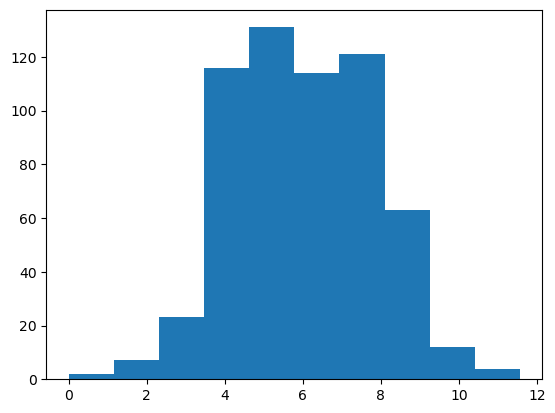

In [27]:
plt.hist(np.log(count_df.sum()));

In [28]:
lig_list = adata.uns['ligand'].values
rec_list = adata.uns['receptor'].values

In [29]:
df_lig_rec = pd.concat(
   [ adata.uns['ligand'], adata.uns['receptor']],
    axis = 1
)

<Axes: xlabel='interaction'>

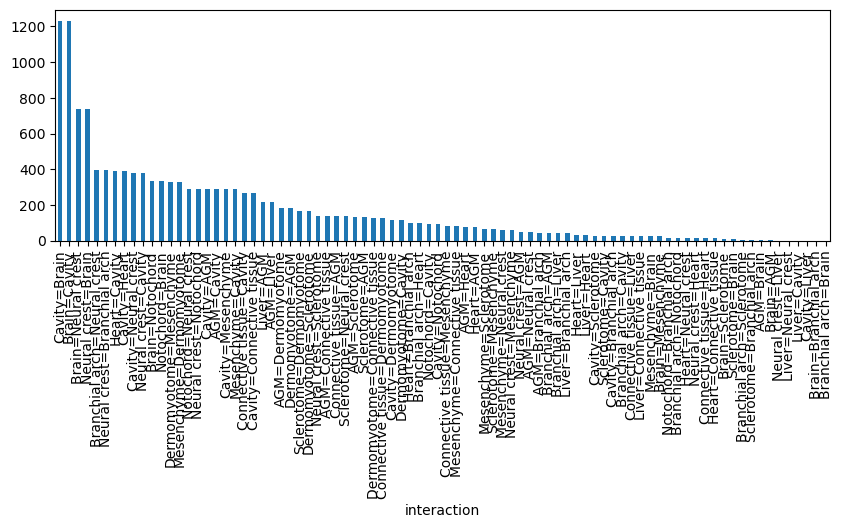

In [30]:
fig, ax = plt.subplots(1,1, figsize=(10,3))
int_edges_new.loc[
int_edges_new.boundary_type == 'External'
].interaction.value_counts().plot(kind='bar',ax =ax)

In [31]:
boundary_type_subsets = int_edges_new.interaction.value_counts()[
    (int_edges_new.interaction.value_counts() > 200)
].index

In [32]:
boundary_type_subsets

Index(['Brain=Brain', 'Neural crest=Neural crest', 'Cavity=Cavity',
       'Heart=Heart', 'Cavity=Brain', 'Brain=Cavity', 'AGM=AGM',
       'Sclerotome=Sclerotome', 'Brain=Neural crest', 'Neural crest=Brain',
       'Connective tissue=Connective tissue', 'Branchial arch=Branchial arch',
       'Branchial arch=Neural crest', 'Neural crest=Branchial arch',
       'Heart=Cavity', 'Cavity=Heart', 'Neural crest=Cavity',
       'Cavity=Neural crest', 'Notochord=Brain', 'Brain=Notochord',
       'Dermomyotome=Mesenchyme', 'Mesenchyme=Dermomyotome',
       'Neural crest=Notochord', 'Notochord=Neural crest', 'Cavity=AGM',
       'AGM=Cavity', 'Mesenchyme=Cavity', 'Cavity=Mesenchyme',
       'Connective tissue=Cavity', 'Cavity=Connective tissue',
       'Notochord=Notochord', 'Mesenchyme=Mesenchyme', 'Liver=AGM',
       'AGM=Liver'],
      dtype='object', name='interaction')

In [33]:
int_edges_subset = int_edges_new.loc[
    int_edges_new.interaction.isin(boundary_type_subsets)
]

In [34]:
int_edges_subset.shape

(27636, 7)

In [35]:
data_list_dict, umi_sums, dist_list_dict = spatial.prepare_data_list(
    count_df,
    int_edges_subset,
    heteromeric=True,
    lig_list=lig_list,
    rec_list = rec_list,
    summarization='sum'
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:36<00:00,  1.07s/it]


In [36]:
cop_df = model.run_copula(
    data_list_dict,
    umi_sums,
    DT=False,
    cutoff = 0.8,
    type_run='dense',
    num_restarts=2,
    df_lig_rec=df_lig_rec,
    heteronomic=True
)

Mesenchyme=Mesenchyme


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    7.6s
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array 

Connective tissue=Connective tissue


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    3.1s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    5.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


AGM=AGM


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    3.7s
[Parallel(n_jobs=20)]: Done 1362 out of 1401 | elapsed:    5.8s remaining:    0.2s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    6.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Sclerotome=Sclerotome


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    4.0s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    6.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning: divide by zero encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning: divide by zero encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
/Users/hs0

Cavity=Cavity
Heart=Heart


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    6.0s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:   10.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Neural crest=Neural crest


[Parallel(n_jobs=20)]: Done 495 tasks      | elapsed:    7.7s
[Parallel(n_jobs=20)]: Done 1190 tasks      | elapsed:   11.8s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:   16.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Branchial arch=Branchial arch


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    3.3s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    5.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Brain=Brain


[Parallel(n_jobs=20)]: Done 359 tasks      | elapsed:    9.0s
[Parallel(n_jobs=20)]: Done 666 tasks      | elapsed:   14.9s
[Parallel(n_jobs=20)]: Done 1362 out of 1401 | elapsed:   22.1s remaining:    0.6s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:   29.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Notochord=Notochord


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    2.4s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    4.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Cavity=Mesenchyme


[Parallel(n_jobs=20)]: Done 752 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    1.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Mesenchyme=Cavity


[Parallel(n_jobs=20)]: Done 720 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    1.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Mesenchyme=Dermomyotome


[Parallel(n_jobs=20)]: Done 524 tasks      | elapsed:    2.6s
[Parallel(n_jobs=20)]: Done 1316 tasks      | elapsed:    3.7s
[Parallel(n_jobs=20)]: Done 1362 out of 1401 | elapsed:    3.9s remaining:    0.1s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    4.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Dermomyotome=Mesenchyme


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    2.2s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    4.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Cavity=Connective tissue


[Parallel(n_jobs=20)]: Done 704 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    2.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Connective tissue=Cavity


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.5s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    3.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearman

Cavity=AGM
AGM=Cavity


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.1s
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


AGM=Liver


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    3.4s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    5.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Liver=AGM


[Parallel(n_jobs=20)]: Done 520 tasks      | elapsed:    2.5s
[Parallel(n_jobs=20)]: Done 1316 tasks      | elapsed:    3.7s
[Parallel(n_jobs=20)]: Done 1362 out of 1401 | elapsed:    3.8s remaining:    0.1s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    4.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning: invalid value encountered in divide
  if (np.isnan( stats.spearmanr(x / _umi_sum_1, y / _umi_sum_2).correlation )):
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:435: RuntimeWarning: invalid value encountered in divid

Cavity=Heart
Heart=Cavity


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.1s


Cavity=Neural crest
Neural crest=Cavity


[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


Branchial arch=Neural crest


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    4.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Neural crest=Branchial arch


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    3.1s
[Parallel(n_jobs=20)]: Done 1362 out of 1401 | elapsed:    4.5s remaining:    0.1s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    5.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Neural crest=Brain


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    3.8s
[Parallel(n_jobs=20)]: Done 1305 tasks      | elapsed:    6.5s
[Parallel(n_jobs=20)]: Done 1362 out of 1401 | elapsed:    6.8s remaining:    0.2s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    7.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Brain=Neural crest


[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 1233 tasks      | elapsed:    4.8s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    6.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Neural crest=Notochord


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    4.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Notochord=Neural crest


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    2.5s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    4.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Brain=Cavity
Cavity=Brain


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    0.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Brain=Notochord


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    1.9s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    3.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Notochord=Brain


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    2.0s
[Parallel(n_jobs=20)]: Done 1401 out of 1401 | elapsed:    3.7s finished


In [37]:
cop_df_dict = cop_df

In [38]:
data_dir = '/Users/hs0424/Workspace/copulacci/notebook/orator_paper_notebook/data/mosta_mouse_embryo/pvals_90/'

In [39]:
import glob

In [40]:
gpairs_selected = [g.split('/')[-1].replace('final_res_copula_','').replace('.csv','') for g in glob.glob(data_dir + '/*.csv')]

In [41]:
import os
dfs = []
for gpair in gpairs_selected:
    file_name = 'final_res_copula_' + gpair + '.csv'
    tmp = pd.read_csv(
        os.path.join(data_dir, file_name),
    )
    tmp.loc[:, 'gpair'] = gpair
    dfs += [tmp.copy()]

In [42]:
cop_sig_df = pd.concat(dfs, axis=0)

In [43]:
cop_sig_df['source'] = cop_sig_df.celltype_direction.str.split("=").str[0]
cop_sig_df['target'] = cop_sig_df.celltype_direction.str.split("=").str[1]

In [140]:
cop_sig_df

,copula_coeff,mu_x,mu_y,copula_method,lig_rec,pval,qval,celltype_direction,gpair,source,target
0,0.107975,-6.381838,-4.297870,copula,CDH1_ITGA1_ITGB1,0.019960,0.033932,Connective tissue=Cavity,Connective tissue=Cavity,Connective tissue,Cavity
1,0.088645,-6.176819,-4.142405,copula,LAMA1_ITGA9_ITGB1,0.065868,0.069985,Connective tissue=Cavity,Connective tissue=Cavity,Connective tissue,Cavity
2,0.129700,-6.552809,-4.146649,copula,LAMB2_ITGA9_ITGB1,0.003992,0.022621,Connective tissue=Cavity,Connective tissue=Cavity,Connective tissue,Cavity
3,0.088062,-6.176632,-4.304586,copula,LAMA1_ITGA7_ITGB1,0.035928,0.046983,Connective tissue=Cavity,Connective tissue=Cavity,Connective tissue,Cavity
4,0.114667,-6.552159,-4.308687,copula,LAMB2_ITGA7_ITGB1,0.013972,0.033932,Connective tissue=Cavity,Connective tissue=Cavity,Connective tissue,Cavity
...,...,...,...,...,...,...,...,...,...,...,...
14,0.117977,-3.691880,-3.855137,copula,FN1_ITGAV_ITGB8,0.101796,0.161178,Notochord=Notochord,Notochord=Notochord,Notochord,Notochord
15,0.092031,-6.235749,-3.860833,copula,LAMB2_ITGAV_ITGB8,0.137725,0.177769,Notochord=Notochord,Notochord=Notochord,Notochord,Notochord
16,0.116070,-6.441894,-5.487313,copula,COL1A2_SDC1,0.137725,0.177769,Notochord=Notochord,Notochord=Notochord,Notochord,Notochord
17,0.113098,-2.592456,-5.101146,copula,MIF_ACKR3,0.149701,0.177769,Notochord=Notochord,Notochord=Notochord,Notochord,Notochord


In [141]:
cop_sig_df.loc[:,'celltype_arrow'] = cop_sig_df.celltype_direction.str.replace("="," → ")

In [194]:
cop_sig_df.to_csv('data/mosta_significant_scores.csv')

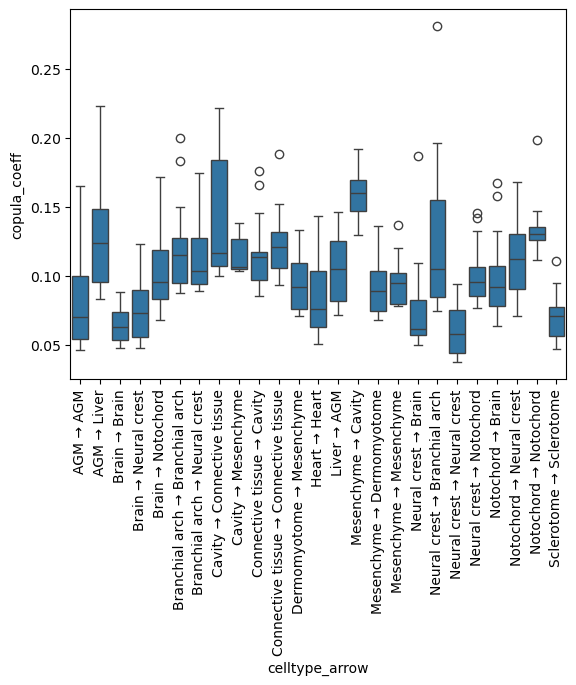

In [142]:
qval_cutoff = 0.1
ax = sns.boxplot(
    data = cop_sig_df.loc[cop_sig_df.qval < qval_cutoff].sort_values(['gpair']),
    x = 'celltype_arrow',
    y = 'copula_coeff'
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

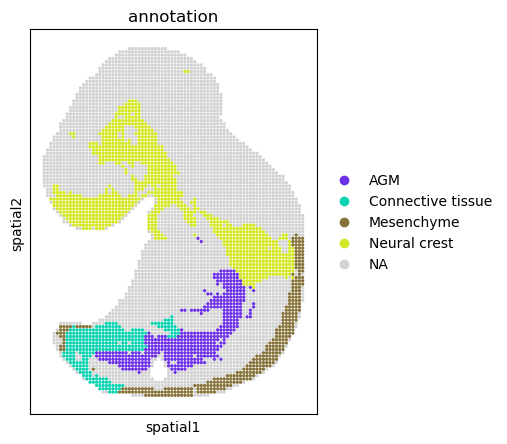

In [59]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
sc.pl.spatial(adata, color = ['annotation'], 
              groups = ['Neural crest', 'AGM', 'Connective tissue', 'Mesenchyme'],
              spot_size=1, ax =ax)

In [145]:
ct = 'Neural crest'
cop_sig_df_tumor = cop_sig_df.loc[
    ((cop_sig_df.source == ct) | (cop_sig_df.target == ct))
].copy()

In [146]:
cop_sig_df_tumor.sort_values(['qval','copula_coeff'],
                             ascending=[True, False]).groupby('celltype_direction').head(3).sort_values(['gpair'])

,copula_coeff,mu_x,mu_y,copula_method,lig_rec,pval,qval,celltype_direction,gpair,source,target,celltype_arrow
18,0.112353,-3.277021,-3.597465,copula,MDK_NCL,0.000000,0.000000,Brain=Neural crest,Brain=Neural crest,Brain,Neural crest,Brain → Neural crest
11,0.104988,-5.893318,-3.921500,copula,LAMA4_CD44,0.000000,0.000000,Brain=Neural crest,Brain=Neural crest,Brain,Neural crest,Brain → Neural crest
20,0.123013,-4.696803,-3.594546,copula,PTN_NCL,0.000000,0.000000,Brain=Neural crest,Brain=Neural crest,Brain,Neural crest,Brain → Neural crest
20,0.101246,-2.707014,-5.375586,copula,IGF2_ITGAV_ITGB3,0.000000,0.000000,Branchial arch=Neural crest,Branchial arch=Neural crest,Branchial arch,Neural crest,Branchial arch → Neural crest
3,0.140490,-6.195033,-4.391134,copula,VTN_ITGA8_ITGB1,0.000000,0.000000,Branchial arch=Neural crest,Branchial arch=Neural crest,Branchial arch,Neural crest,Branchial arch → Neural crest
17,0.174526,-6.129745,-6.067165,copula,SEMA3C_PLXND1,0.005988,0.021956,Branchial arch=Neural crest,Branchial arch=Neural crest,Branchial arch,Neural crest,Branchial arch → Neural crest
21,0.109590,-3.588395,-5.937869,copula,MDK_PTPRZ1,0.000000,0.000000,Neural crest=Brain,Neural crest=Brain,Neural crest,Brain,Neural crest → Brain
22,0.186837,-6.372803,-5.899221,copula,PDGFC_PDGFRA,0.000000,0.000000,Neural crest=Brain,Neural crest=Brain,Neural crest,Brain,Neural crest → Brain
15,0.089861,-5.535872,-4.089527,copula,LAMA1_CD44,0.000000,0.000000,Neural crest=Brain,Neural crest=Brain,Neural crest,Brain,Neural crest → Brain
5,0.176169,-6.031437,-5.810682,copula,JAG2_NOTCH2,0.000000,0.000000,Neural crest=Branchial arch,Neural crest=Branchial arch,Neural crest,Branchial arch,Neural crest → Branchial arch


In [185]:
sdm_df_dict[int_type].loc[
    sdm_df_dict[int_type].pathway_name == 'EPHB']

,interaction_name,pathway_name,agonist,antagonist,co_A_receptor,co_I_receptor,evidence,annotation,interaction_name_2,global_I,global_pval
EFNB2_EPHB4,EFNB2_EPHB4,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb2 - Ephb4,-0.019963,1.000000e+00
EFNB3_EPHA4,EFNB3_EPHA4,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb3 - Epha4,-0.025448,1.000000e+00
EFNB3_EPHB1,EFNB3_EPHB1,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb3 - Ephb1,-0.026133,1.000000e+00
EFNB3_EPHB2,EFNB3_EPHB2,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb3 - Ephb2,0.033659,3.494873e-44
EFNB3_EPHB3,EFNB3_EPHB3,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb3 - Ephb3,-0.012981,1.000000e+00
EFNB3_EPHB4,EFNB3_EPHB4,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb3 - Ephb4,0.010076,2.942267e-05
EFNB2_EPHB3,EFNB2_EPHB3,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb2 - Ephb3,0.019489,7.674826e-16
EFNB2_EPHB2,EFNB2_EPHB2,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb2 - Ephb2,0.047433,4.343888e-86
EFNB2_EPHB1,EFNB2_EPHB1,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb2 - Ephb1,-0.004805,1.000000e+00
EFNB2_EPHA4,EFNB2_EPHA4,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb2 - Epha4,0.044347,1.817188e-75


In [184]:
sdm_df_dict[int_type]

,interaction_name,pathway_name,agonist,antagonist,co_A_receptor,co_I_receptor,evidence,annotation,interaction_name_2,global_I,global_pval
EFNB2_EPHB4,EFNB2_EPHB4,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb2 - Ephb4,-0.019963,1.000000e+00
EFNB3_EPHA4,EFNB3_EPHA4,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb3 - Epha4,-0.025448,1.000000e+00
EFNB3_EPHB1,EFNB3_EPHB1,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb3 - Ephb1,-0.026133,1.000000e+00
EFNB3_EPHB2,EFNB3_EPHB2,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb3 - Ephb2,0.033659,3.494873e-44
EFNB3_EPHB3,EFNB3_EPHB3,EPHB,NaN,NaN,NaN,NaN,PMID: 15114347,Cell-Cell Contact,Efnb3 - Ephb3,-0.012981,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
MIF_CD74_CXCR4,MIF_CD74_CXCR4,MIF,NaN,NaN,NaN,NaN,PMID: 29637711; PMID: 24760155,Secreted Signaling,Mif - (Cd74+Cxcr4),-0.018455,1.000000e+00
CXCL12_ACKR3,CXCL12_ACKR3,CXCL,NaN,NaN,NaN,NaN,KEGG: mmu04060,Secreted Signaling,Cxcl12 - Ackr3,0.032978,1.709030e-42
CXCL12_CXCR4,CXCL12_CXCR4,CXCL,NaN,NaN,NaN,NaN,KEGG: mmu04060,Secreted Signaling,Cxcl12 - Cxcr4,0.049282,8.868466e-93
CTF1_LIFR_IL6ST,CTF1_LIFR_IL6ST,LIFR,NaN,NaN,NaN,NaN,KEGG: mmu04060,Secreted Signaling,Ctf1 - (Lifr+Il6st),-0.000210,9.183946e-01


In [174]:
cop_sig_df_tumor.loc[cop_sig_df_tumor.lig_rec == 'EFNB1_EPHB2']

,copula_coeff,mu_x,mu_y,copula_method,lig_rec,pval,qval,celltype_direction,gpair,source,target,celltype_arrow
3,0.196263,-5.93136,-6.433729,copula,EFNB1_EPHB2,0.0,1.192093e-07,Neural crest=Branchial arch,Neural crest=Branchial arch,Neural crest,Branchial arch,Neural crest → Branchial arch


In [175]:
cop_sig_df_tumor.qval = cop_sig_df_tumor.qval + EPSILON
cop_sig_df_tumor.pval = cop_sig_df_tumor.pval + EPSILON

In [176]:
import gseapy_like_plot as pl

p_inv


<Axes: xlabel='celltype_direction'>

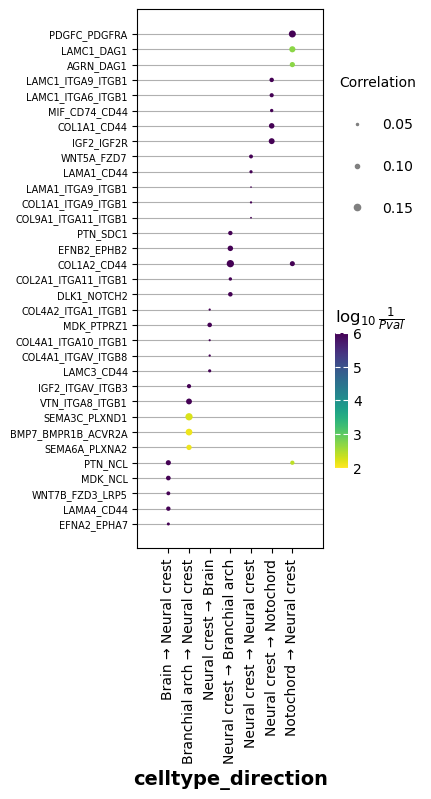

In [179]:
pl.dotplot(
    cop_sig_df_tumor,
    columns = 'qval',
    x = 'celltype_direction',
    y = 'lig_rec',
    xlabelsize=10,
    ylabelsize=7,
    figsize=(3,7),
    xticklabels_rot=90,
    show_ligrec_dir=False,
    top_term=5,
    cutoff=0.01,
    size=5,
)

In [155]:
loc = adata.obsm['spatial']

loc_df = pd.DataFrame(loc).rename(columns = {0:"x", 1:"y"})
loc_df.loc[:,"cell"] = adata.obs_names
loc_df.set_index('cell', inplace=True)

In [50]:

from matplotlib.colors import Normalize



def plot_raw_lr_boundary_expression(
    lig_rec_idx,
    int_type,
    loc_df,
    int_edges_new,
    shrink_fraction = 1.0,
):
    lr_pairs_ct = int_edges_new.loc[
        int_edges_new.interaction == int_type,
        :
    ].copy()
    genes_to_show = [gene.capitalize() for gene in lig_rec_idx.split("_")]
    genes_to_show = [gene for gene in genes_to_show if gene in count_df.columns]
    
    #sns.scatterplot(data = int_loc_df, x = "x", y = "y", s = 8, hue='dist_from_z', ax=ax, alpha=0.8,label='start')
    selected_cells = list(
        set(lr_pairs_ct.cell1.unique()).union(
            lr_pairs_ct.cell2.unique()   
        )
    )
    
    fig, ax = plt.subplots(1,len(genes_to_show),
                           figsize=(5*len(genes_to_show),5))
    for i,gene in enumerate(genes_to_show):
        ax[i].scatter(loc_df['x'], loc_df['y'], c= "grey", s=0.4,alpha = 0.4)
        colors = np.array(count_df.loc[selected_cells, gene].values)
        tmp = loc_df.loc[selected_cells,:].copy()
        tmp.loc[:, 'gene'] = colors
        sns.scatterplot(x='x', y='y', hue='gene',
                             palette='Reds',s=10, 
                        data=tmp,alpha=0.7,ax= ax[i])

        norm = Normalize(tmp['gene'].min(), tmp['gene'].max())
        sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
        sm.set_array([])

        cbar = plt.colorbar(sm, ax=ax[i],shrink=shrink_fraction)
        # Remove the legend and add a colorbar
        ax[i].get_legend().remove()
        
    
        ax[i].set_title(gene + "\n" + int_type.replace('=',' → '))
        #ax[i].figure.colorbar(sm,ax=ax[i])
        ax[i].invert_yaxis()
        ax[i].set_xticks([])
        ax[i].set_yticks([]);
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['bottom'].set_visible(False)
        ax[i].spines['left'].set_visible(False)
    
        ax[i].set_xlabel("spatial1")
        ax[i].set_ylabel("spatial2")
    plt.tight_layout()
    plt.show()

In [51]:
def plot_lr_interaction_boundary_activity_color(
    df_lig_rec,
    lig_rec_idx,
    int_type,
    cop_df_dict,
    loc_df,
    int_edges_new,
    umi_sums,
    data_list_dict,
    dist_list_dict = None,
    shrink_fraction = 1.0,
):
    
    idx = df_lig_rec.index.get_loc(lig_rec_idx)
    g11, g12 = int_type.split('=')
    if dist_list_dict is None:
        
        row = cop_df_dict[int_type].loc[lig_rec_idx,:]
        coeff = row.copula_coeff
        mu_x = row.mu_x
        mu_y = row.mu_y
        loglikvec =  model.log_joint_lik_perm(
            [coeff,mu_x,mu_y],
            umi_sums[int_type][g11],
            umi_sums[int_type][g12],
            data_list_dict[int_type][idx][0],
            data_list_dict[int_type][idx][1],
            perm=20,
            DT=False,
            model='copula',
            return_sum=False
        )
        loglikvec = -loglikvec
    else:
        g11, g12 = int_name.split('=')
        row = cop_df_dict[int_type].loc[lig_rec_idx,:]
        rho_zero = row.rho_zero
        rho_one = row.rho_one
        mu_x = row.mu_x
        mu_y = row.mu_y
        loglikvec =  model.log_joint_lik_perm_dist(
            [rho_zero,rho_one,mu_x,mu_y],
            umi_sums[int_type][g11],
            umi_sums[int_type][g12],
            data_list_dict[int_type][idx][0],
            data_list_dict[int_type][idx][1],
            dist_list_dict[int_name],
            perm=20,
            DT=False,
            model='copula',
            return_sum=False
        )
        loglikvec = -loglikvec
        
    lr_pairs_ct = int_edges_new.loc[
        int_edges_new.interaction == int_type,
        :
    ].copy()
    fig, ax = plt.subplots(figsize=(6,6))
    cmap = plt.get_cmap('Reds')
    norm = Normalize(vmin=min(loglikvec), vmax=max(loglikvec))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([]) 
    # Remove the legend and add a colorbar
    ax.scatter(loc_df['x'], loc_df['y'], c= "grey",
               s=0.4,alpha = 0.4)
    #sns.scatterplot(data = int_loc_df, x = "x", y = "y", s = 8, hue='dist_from_z', ax=ax, alpha=0.8,label='start')
    
    for i,edge in enumerate(lr_pairs_ct[['cell1', 'cell2']].values):
        color = cmap(norm(loglikvec[i]))
        x1, y1 = loc_df.loc[  edge[0], 'x' ], loc_df.loc[  edge[0], 'y' ]
        x2, y2 = loc_df.loc[  edge[1], 'x' ], loc_df.loc[  edge[1], 'y' ]
        ax.plot([x1, x2], [y1, y2], color=color, marker='o', 
                linestyle='-', markersize=0.5,linewidth=1)
    cbar = plt.colorbar(sm, ax=ax,shrink=shrink_fraction,
                        label='Loglikelihood')
    #ax.get_legend().remove()
    ax.set_title(lig_rec_idx + "\n" + int_type.replace('=',' → '))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.gca().invert_yaxis()
    plt.gca().set_xticks([])
    plt.gca().set_yticks([]);
    plt.xlabel("spatial1")
    plt.ylabel("spatial2")

In [52]:
loc = adata.obsm['spatial']

loc_df = pd.DataFrame(loc).rename(columns = {0:"x", 1:"y"})
loc_df.loc[:,"cell"] = adata.obs_names
loc_df.set_index('cell', inplace=True)

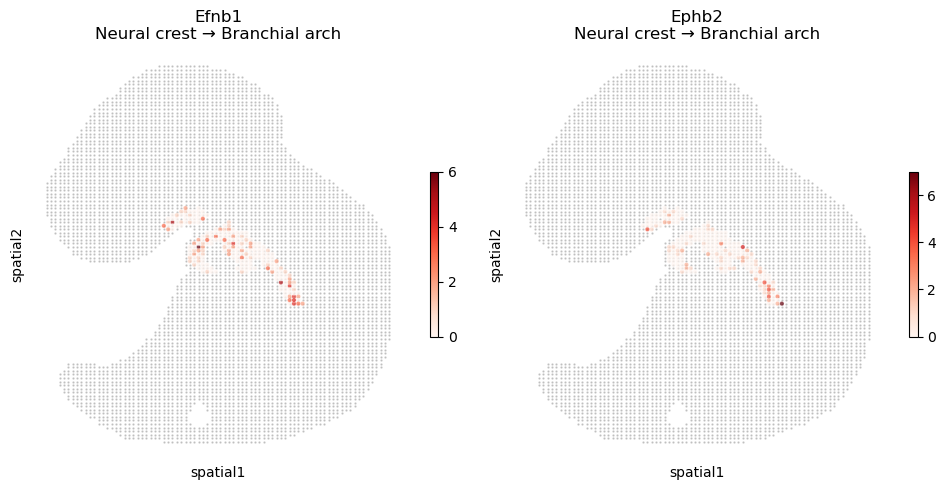

In [53]:
lig_rec_idx = 'EFNB1_EPHB2'
int_type = 'Neural crest=Branchial arch'
plot_raw_lr_boundary_expression(
    lig_rec_idx,
    int_type,
    loc_df,
    int_edges_new,
    shrink_fraction=0.4
)

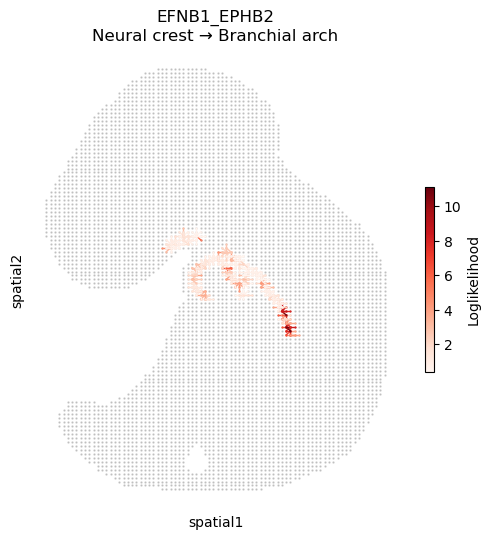

In [54]:
plot_lr_interaction_boundary_activity_color(
    df_lig_rec,
    lig_rec_idx,
    int_type,
    cop_df_dict,
    loc_df,
    int_edges_new,
    umi_sums,
    data_list_dict,
    shrink_fraction=0.4
)

In [57]:
def plot_lr_3d_hist(
    df_lig_rec,
    lig_rec_idx,
    int_type,
    data_list_dict,
):
    
    idx = df_lig_rec.index.get_loc(lig_rec_idx)
    lig,rec = lig_rec_idx.split('_')[:2]
    lig = lig.capitalize()
    rec = rec.capitalize()
    g11, g12 = int_type.split('=')
    x = data_list_dict[int_type][idx][0]
    y = data_list_dict[int_type][idx][1]
    fig = plt.figure()          #create a canvas, tell matplotlib it's 3d
    ax = fig.add_subplot(111, projection='3d')
    
    #make histogram stuff - set bins - I choose 20x20 because I have a lot of data
    hist, xedges, yedges = np.histogram2d(x, y, bins=(20,20))
    xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])
    
    xpos = xpos.flatten()/2.
    ypos = ypos.flatten()/2.
    zpos = np.zeros_like (xpos)
    
    dx = xedges [1] - xedges [0]
    dy = yedges [1] - yedges [0]
    dz = hist.flatten()
    
    cmap = plt.cm.get_cmap('Reds') # Get desired colormap - you can change this!
    max_height = np.max(dz)   # get range of colorbars so we can normalize
    min_height = np.min(dz)
    # scale each z to [0,1], and get their rgb values
    rgba = [cmap((k-min_height)/max_height) for k in dz] 
    
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')
    plt.xlabel(lig,fontsize=15)
    plt.ylabel(rec,fontsize=15)

/var/folders/g1/3dtmjp_93t98h_hcw8xs6l5w0000gn/T/ipykernel_65494/1991591607.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Reds') # Get desired colormap - you can change this!


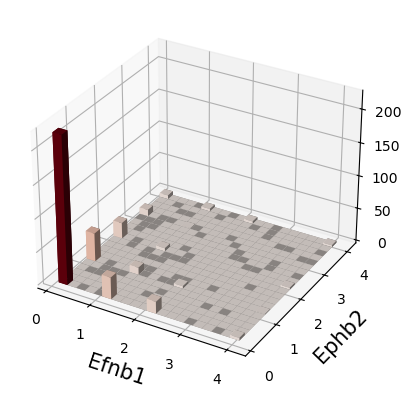

In [58]:
lig_rec_idx = 'EFNB1_EPHB2'
plot_lr_3d_hist(
    df_lig_rec,
    lig_rec_idx,
    int_type,
    data_list_dict,
)

In [187]:
sdm_df_dict[int_type].loc[
    sdm_df_dict[int_type].pathway_name == 'EPHB'].global_I

EFNB2_EPHB4   -0.019963
EFNB3_EPHA4   -0.025448
EFNB3_EPHB1   -0.026133
EFNB3_EPHB2    0.033659
EFNB3_EPHB3   -0.012981
EFNB3_EPHB4    0.010076
EFNB2_EPHB3    0.019489
EFNB2_EPHB2    0.047433
EFNB2_EPHB1   -0.004805
EFNB2_EPHA4    0.044347
EFNB1_EPHA4    0.036231
EFNB1_EPHB1    0.177448
EFNB1_EPHB2    0.036233
EFNB1_EPHB3    0.004274
EFNB1_EPHB4   -0.010651
Name: global_I, dtype: float64

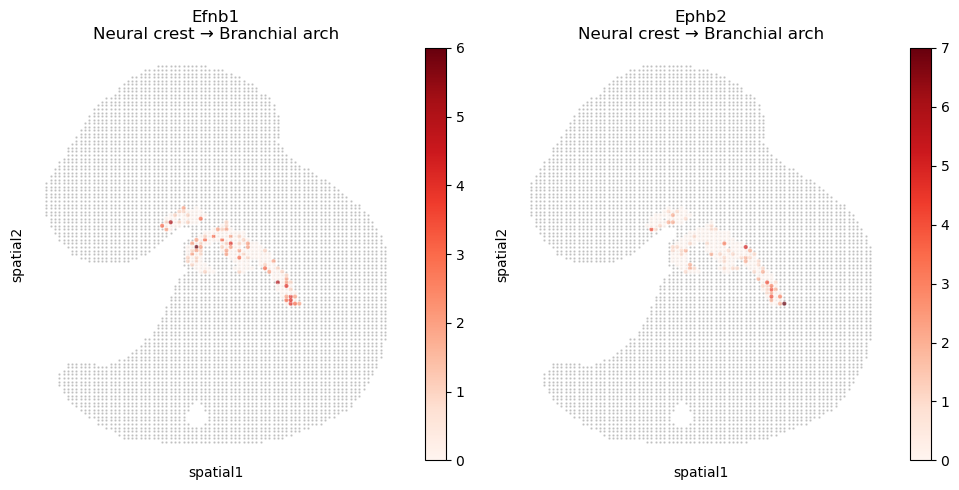

In [192]:
lig_rec_idx = 'EFNB1_EPHB2'
int_type = 'Neural crest=Branchial arch'
plot_raw_lr_boundary_expression(
    lig_rec_idx,
    int_type,
    loc_df,
    int_edges_new
)

In [191]:
cop_df_dict[int_type].loc['EFNB1_EPHB1']

copula_coeff          0.0
mu_x                  0.0
mu_y                  0.0
copula_method        skip
scc              0.030477
Name: EFNB1_EPHB1, dtype: object

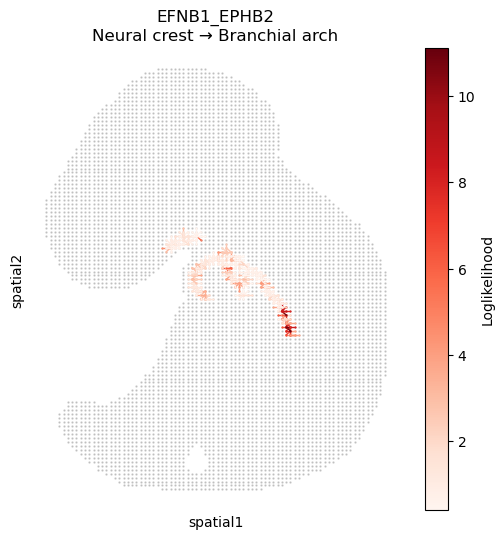

In [193]:
plot_lr_interaction_boundary_activity_color(
    df_lig_rec,
    lig_rec_idx,
    int_type,
    cop_df_dict,
    loc_df,
    int_edges_new,
    umi_sums,
    data_list_dict
)

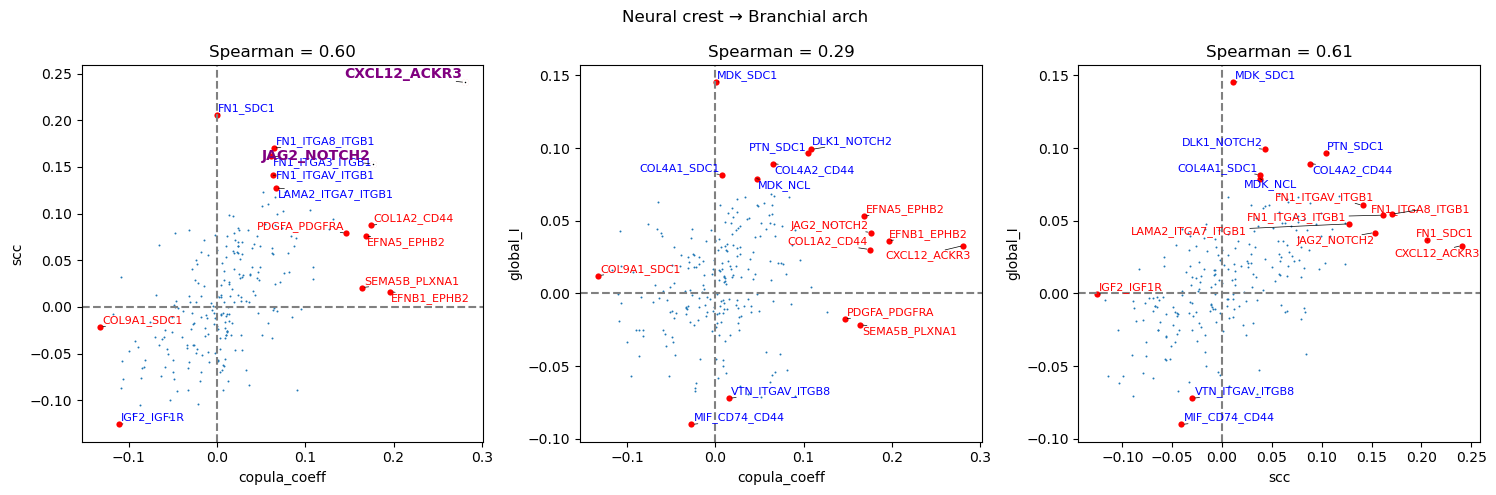

In [167]:
ntop = 8
for gpair in [int_type]:
    res = merged_res[gpair].copy()
    #res = res.drop_duplicates(['ligand', 'receptor'])
    # only take non sparse entries
    
    res = res.loc[res.copula_method == 'copula'].fillna(0)
    res = res.loc[res.index.str.split('_').str[0] != res.index.str.split('_').str[1]]
    if res.shape[0] < 5:
        continue
    ncol = len(score_pair)
    _, ax = plt.subplots(1,ncol, figsize=(5*ncol,5))
    for i,(x_col, y_col) in enumerate(score_pair):
        
        sig1 = res.sort_values(by=x_col, key=lambda x: abs(x), ascending=False)[:ntop]
        sig2 = res.sort_values(by=y_col, key=lambda x: abs(x), ascending=False)[:ntop]

        sig12 = sig1.join(sig2, rsuffix='_2',how='inner')
        
        sns.scatterplot(data = res, 
                        x = x_col, 
                        y = y_col, s = 2, linewidth = 0,ax = ax[i])
        sns.scatterplot(
                data = sig1, 
                x = x_col, 
                y = y_col, 
                s = 20, c='r', linewidth = 0,ax = ax[i])
        sns.scatterplot(
                data = sig2, 
                x = x_col,
                y = y_col, 
                s = 20, c='r', linewidth = 0,ax = ax[i])

        text_sig = []
        for j,r in sig1.drop(sig12.index).iterrows():
            text_sig.append(ax[i].text(x=r[x_col], y = r[y_col], 
                                        s = j,
                                        color=(1, 0, 0),
                                        fontsize = 8
                                    ))
        
        for j,r in sig2.drop(sig12.index).iterrows():
            text_sig.append(ax[i].text(x=r[x_col], y = r[y_col], 
                                        s = j,
                                        color=(0, 0, 1),
                                        fontsize = 8
                                    ))
        
        if(len(text_sig) > 0):
            adjust_text(text_sig,arrowprops=dict(arrowstyle="-", color='black', lw=0.5),ax=ax[i])
        
        if (len(sig12) > 0):
            sns.scatterplot(data = sig12, 
                                x = x_col, y = y_col, s = 10, c='black', linewidth = 2,
                                ax = ax[i])
            text_sig12 = []
            for j,r in sig12.iterrows():
                text_sig12.append(ax[i].text(x=r[x_col], y = r[y_col], 
                                            s = j,
                                            color = (0.5, 0, 0.5),
                                            fontsize = 10,
                                            weight='bold'
                                        ))
            adjust_text(text_sig12,arrowprops=dict(arrowstyle="-", color='black', lw=0.5),ax=ax[i])
        ax[i].set_title(f'Spearman = { stats.spearmanr(res[x_col].values, res[y_col].values)[0] :.2f}')
        ax[i].axhline(0, color='grey', linestyle='--')
        ax[i].axvline(0, color='grey', linestyle='--')
        
    
    plt.suptitle(gpair.replace('=',' → '))
    plt.tight_layout()
    plt.show()